In [ ]:
#Uncomment if you're using colab
#Setting up google drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

In [4]:
import my_utils as mu
import torch
from torch import nn
from IPython import display

# Concise Implementation of Softmax Regression

* Goal: use high-level APIs of PyTorch for implementing Softmax Regression for classification. 

In [5]:
batch_size = 256
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
# type(train_iter)

0.5%

100.0%


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%
1.5%

Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



In [6]:
X, y = next(iter(train_iter)) # first batch
print(X.size())
print(y)

torch.Size([256, 1, 28, 28])
tensor([2, 4, 4, 8, 9, 5, 0, 3, 0, 9, 4, 8, 0, 2, 5, 4, 1, 1, 0, 7, 0, 1, 7, 7,
        7, 2, 4, 0, 1, 3, 9, 4, 9, 6, 7, 8, 6, 9, 4, 8, 7, 2, 9, 5, 7, 7, 2, 8,
        9, 0, 7, 0, 4, 8, 1, 7, 0, 8, 2, 5, 0, 8, 0, 7, 2, 6, 1, 2, 2, 9, 4, 9,
        1, 6, 6, 6, 2, 9, 7, 9, 6, 0, 3, 7, 3, 5, 8, 7, 2, 7, 9, 5, 3, 3, 8, 7,
        6, 7, 7, 3, 8, 0, 1, 1, 2, 7, 7, 2, 1, 3, 4, 2, 4, 5, 0, 9, 7, 0, 8, 5,
        5, 7, 1, 8, 5, 3, 3, 3, 7, 2, 6, 3, 2, 6, 2, 6, 4, 8, 2, 9, 3, 3, 3, 3,
        5, 7, 2, 8, 9, 1, 2, 6, 5, 5, 9, 0, 2, 0, 9, 7, 1, 5, 8, 2, 5, 6, 9, 2,
        4, 7, 5, 5, 3, 7, 8, 7, 1, 5, 0, 7, 2, 1, 9, 5, 2, 8, 0, 0, 2, 2, 9, 0,
        5, 3, 8, 7, 5, 7, 6, 1, 1, 1, 7, 2, 6, 3, 6, 8, 5, 6, 7, 2, 6, 4, 1, 5,
        9, 6, 9, 3, 7, 6, 7, 6, 0, 3, 7, 7, 1, 1, 6, 2, 5, 5, 1, 0, 9, 2, 0, 0,
        4, 6, 5, 4, 9, 0, 9, 0, 2, 4, 1, 3, 3, 5, 1, 8])


# Defining the Model and Initialization

* Each example is represented by a fixed-length vector: we flatten each $28 \times 28$ image, treating it as vector of length 784.

* Because our dataset has 10 classes, our network will have an output dimension of 10.
* So, our weights `W` will be a $784 \times 10$ matrix and the biases `b` will constitute a $10 \times 1$ row vector.
* We initialize `W` using a Gaussian distribution and `b` with 0.
* Softmax regression can be implemented as a Fully-Connected (i.e Linear) layer.


In [8]:
class Net(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.Linear1 = nn.Linear(num_inputs, num_outputs)
        torch.nn.init.normal_(self.Linear1.weight, std=0.01) #init the weights
        torch.nn.init.zeros_(self.Linear1.bias) #init the bias
        
    def forward(self, x):
        x = x.view(-1, self.num_inputs)
        out = self.Linear1(x)
        return out

num_inputs, num_outputs = 784, 10
net = Net(num_inputs, num_outputs)
print(net)

Net(
  (Linear1): Linear(in_features=784, out_features=10, bias=True)
)


# Alternative Initialization
* This is useful if you have multiple layers of the same type and you want them to be initialized in the same way.

In [10]:
def init_weights(m):
    if isinstance(m, nn.Linear): # by checking type we can init different layers in different ways
        torch.nn.init.normal_(m.weight, std=0.01)
        torch.nn.init.zeros_(m.bias)

net.apply(init_weights);
print(net)

Net(
  (Linear1): Linear(in_features=784, out_features=10, bias=True)
)


# Loss Function

* Use PyTorch's implementation of Softmax-Cross Entropy loss to avoid numerical instabilities.
    * The input to loss function are the logits logits $\mathbf{o}$ (and not softmax outputs)

In [12]:
loss = nn.CrossEntropyLoss()


CrossEntropyLoss()


# Optimization Algorithm


* Minibatch SGD with a learning rate of 0.1 as the optimization algorithm.


In [13]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

# Evaluation


In [14]:
def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class.
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # Predicted class is the index of max score         
    cmp = (y_hat.type(y.dtype) == y)  # because`==` is sensitive to data types
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.

# Example: only 1 sample is correctly classified.
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
accuracy(y_hat, y) / len(y)

0.5

In [20]:
class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [21]:
def evaluate_accuracy(net, data_iter): 
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

* The accuracy of the model prior to training should be close to random guessing, i.e., 0.1 for 10 classes.


In [19]:
evaluate_accuracy(net, test_iter) 

0.0302

# Training

* The training loop for softmax regression looks strikingly familiar with that of linear regression. 
* Here we refactor the implementation to make it reusable.
    * First, we define a function to train for one epoch.

In [22]:
def train_epoch_ch3(net, train_iter, loss, optimizer):  
    """The training function for one epoch."""


    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()


    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:


        # Compute gradients and update parameters
        y_hat = net(X) ##this the foward function and we get the predictions
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())


    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

# Training

* The following class will be used to plot training and validation accuracy as well as loss evolution over training loop. 

In [25]:
class Animator:  
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        mu.use_svg_display()
        self.fig, self.axes = mu.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: mu.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

# Training

* The following function trains the model (`net`) on a training set (`train_iter`) for `num_epochs`.
* At the end of each epoch, the model is evaluated on a testing set (`test_iter`).
* `Animator` for visualizing the training progress.

In [26]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer):  
    """Train a model."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, optimizer)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

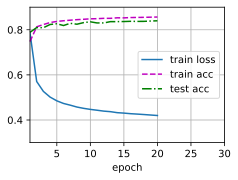

In [27]:
num_epochs = 30
train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer)

# Summary

* Using PyTorch's high-level APIs, we can implement softmax regression much more concisely.
* From a computational perspective, implementing softmax regression has intricacies. 
* Note that in many cases, PyTorch takes additional precautions beyond these most well-known tricks to ensure numerical stability